# Regression with Bayesian Neural Networks

Note: The model used here is the modified version used in http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/. A few lines of boilerplate code is also used. The rest is written specifically for this project

In [13]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
import pickle
import theano
import theano.tensor as T
import os
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.style.use('seaborn')
sns.set_context("poster",font_scale=1)
%matplotlib inline

### Creating the data and the initial plot of the whole set

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise, x_interval__]
100%|██████████| 1500/1500 [00:02<00:00, 688.24it/s]


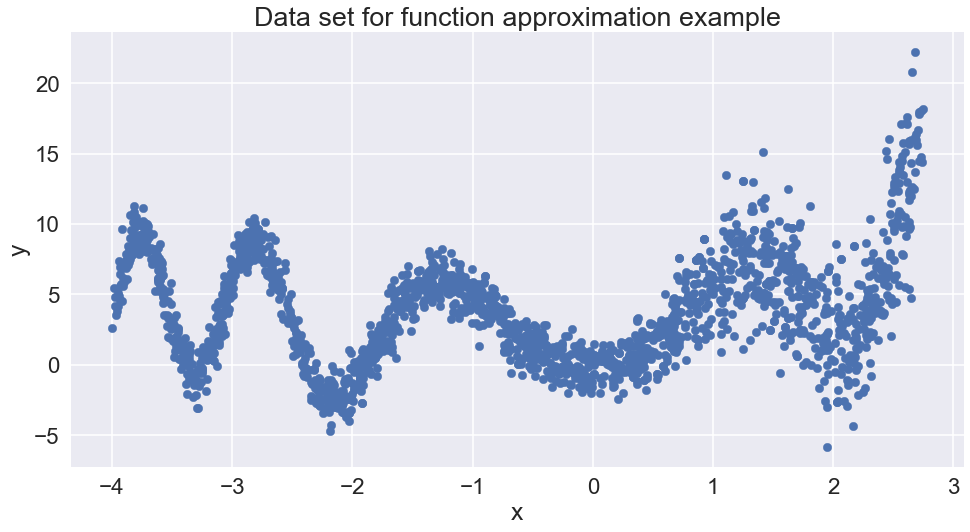

In [931]:

if os.path.exists("reg_data---"):
    with open("reg_data","rb") as f:
        data = pickle.load(f)
else:
    m = pm.Model()
    lower=-4
    upper=2.75
    #3
    with m:
        x = pm.Uniform("x", lower=lower, upper=upper, testval=0.1)
        noise = pm.Normal("noise", mu=0, sd=1+(x>0.1)*abs(x), testval=0.1)
        #noise = pm.Normal("noise", mu=0, sd=1+np.sqrt(4-np.abs(x))**2, testval=0.1)
        #y = pm.Deterministic("y", 5*np.sin(x**2)+ x ** 2 + (x ** 3)/(2*np.sqrt(abs(x))) + x/5 + noise)
        y = pm.Deterministic("y", 5*np.sin(x**2)+ x ** 2 + (x ** 3)/6 + x/5 + noise)
        trace = pm.sample(1000)
    X = trace.get_values("x")
    y = trace.get_values("y")

    data = [X, y]
    with open("reg_data","wb") as f:
        pickle.dump(data, f)

X, y = data
        
plt.figure(figsize=(16,8))
plt.title("Data set for function approximation example")
plt.ylabel("y")
plt.xlabel("x")
plt.scatter(X ,y, s=70)

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Data set for function approximation example")
plt.ylabel("y")
plt.xlabel("x")
plt.scatter(X ,y, s=70)

In [23]:
def plot_ppc(X, y, algorithm, ppc, n_lines=500, pred=True, scatter=True):
    all_data = ppc["out"]
    idx = np.random.choice(range(all_data.shape[0]), size=n_lines, replace=False)
    plt.figure(figsize=(16,6))
    if pred:
        pred = all_data.mean(axis=0)
        data = np.array([X_test[:,0], pred]).transpose()
        data = data[data[:,0].argsort()]
        plt.plot(data[:,0], data[:,1], c="r", lw=3)
    if scatter:
        plt.scatter(X[:,0],y, s=70)
    """
    for i in idx:
        data = np.array([X_test[:,0], all_data[i,:]]).transpose()
        data = data[data[:,0].argsort()]
        plt.plot(data[:,0], data[:,1], alpha=0.01, c="r")
    """
    percentiles = np.percentile(ppc["out"], [1, 99], axis=0)
    data = np.array([X_test[:,0], percentiles[0]]).transpose()
    per_low = data[data[:,0].argsort()]
    data = np.array([X_test[:,0], percentiles[1]]).transpose()
    per_high = data[data[:,0].argsort()]
    plt.fill_between(per_low[:,0], per_low[:,1], per_high[:,1], alpha=0.30)
   
    #plt.title("Neural network regression with {} sampling".format(algorithm))
    plt.ylabel("y")    
    plt.xlabel("x")    
    
def calculate_percentiles(mh_ppc, X_test):
    percentiles = np.percentile(mh_ppc["out"], [1, 99], axis=0)
    data = np.array([X_test[:,0], percentiles[0]]).transpose()
    per_low = data[data[:,0].argsort()]
    data = np.array([X_test[:,0], percentiles[1]]).transpose()
    per_high = data[data[:,0].argsort()]
    return per_low[:,0], per_low[:,1], per_high[:,1]
    
def plot_both(X_test, y_test, mh_ppc, nuts_ppc):
    mh_data = mh_ppc["out"]
    nuts_data = nuts_ppc["out"]
    
    f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    f.set_size_inches(16,12)
    
    mh_pred = mh_data.mean(axis=0)
    mh_mean = np.array([X_test[:,0], mh_pred]).transpose()
    mh_mean = mh_mean[mh_mean[:,0].argsort()]
    ax1.plot(mh_mean[:,0], mh_mean[:,1], c="r", lw=3)
    ax1.scatter(X_test[:,0],y_test, s=70)
    x, lower, upper = calculate_percentiles(mh_ppc, X_test)
    
    ax1.fill_between(x, lower, upper, alpha=0.30)
    ax1.set_ylabel("y")    
    ax1.set_xlabel("x")
    ax1.set_title("MH-MCMC")
    
    nuts_pred = nuts_data.mean(axis=0)
    nuts_mean = np.array([X_test[:,0], nuts_pred]).transpose()
    nuts_mean = nuts_mean[nuts_mean[:,0].argsort()]
    ax2.plot(nuts_mean[:,0], nuts_mean[:,1], c="r", lw=3)
    ax2.scatter(X_test[:,0],y_test, s=70)
    x, lower, upper = calculate_percentiles(nuts_ppc, X_test)
    ax2.set_title("HMC-NUTS")
    
    ax2.fill_between(x, lower, upper, alpha=0.30)
    ax2.set_ylabel("y")    
    ax2.set_xlabel("x")
    
    f.savefig("regression.jpg", dpi=500)


### Creating and sampling from the neural network model

In [933]:
X = pd.DataFrame(X)
X["1"] = 1
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [934]:
N=1000
n_units=5

init_in_1 = np.random.randn(X.shape[1], n_units)
init_1_2 = np.random.randn(n_units + 1, n_units)
init_2_out = np.random.randn(n_units + 1, 1)

### MHMCMC

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
100%|██████████| 1000/1000 [00:00<00:00, 1502.99it/s]


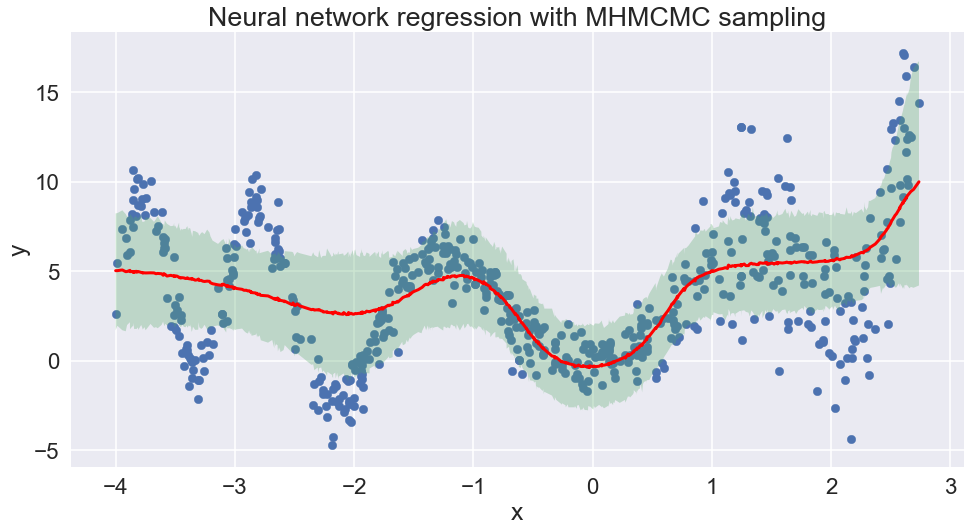

In [935]:
ann_input = theano.shared(X_train)
#ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
ann_output = theano.shared(y_train)

mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

    act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
    act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
    act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
    act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
    act_out = T.dot(act_2,w_2_out)
    out = pm.Normal('out', act_out.flatten(), sd = 1, observed=ann_output)   
    
    step=pm.Metropolis()
    trace = pm.sample(N, step=step)
    
ann_input.set_value(X_test)
ann_output.set_value(y_test)
ppc=pm.sample_ppc(trace, model=mlc, samples=1000)

plot_ppc(X_test, y_test, "MHMCMC", ppc, n_lines=1000)

In [936]:
summary_mh = pm.stats.summary(trace)

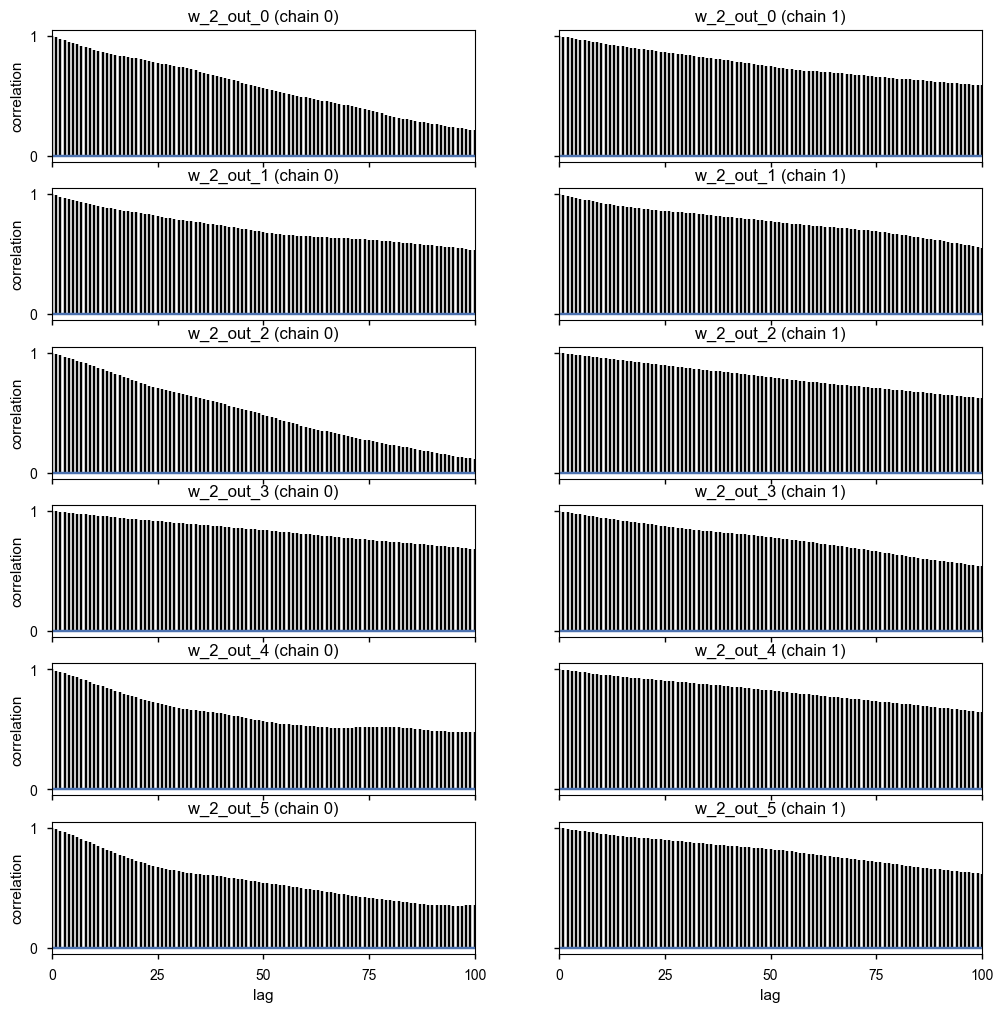

In [937]:
plt.style.use('default')
sns.set_context("notebook",font_scale=1)
autocorrplots_mh = pm.plots.autocorrplot(trace, varnames=["w_2_out"])
plt.style.use('seaborn')
sns.set_context("poster",font_scale=1.4)

### HMC-NUTS

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
100%|██████████| 1500/1500 [17:00<00:00,  1.71it/s]/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.908213333632, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))

/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.

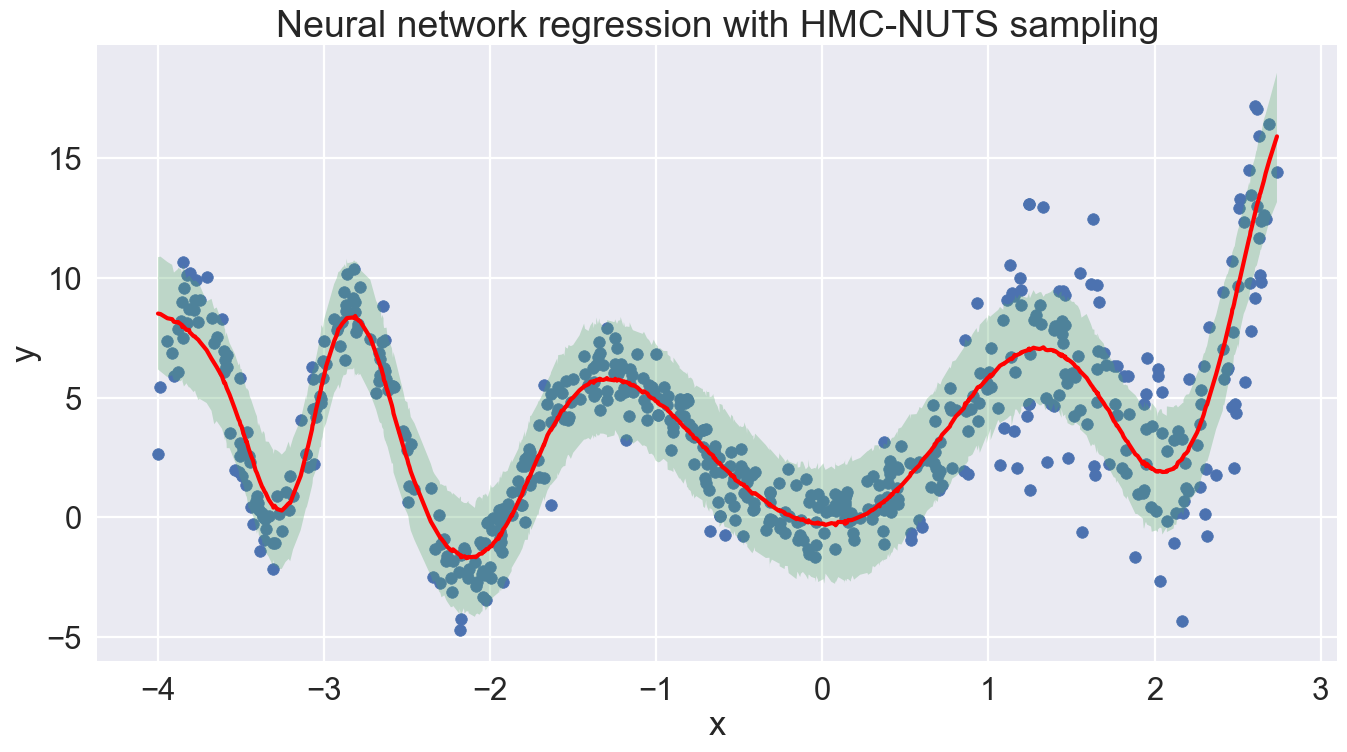

In [941]:
ann_input = theano.shared(X_train)
#ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
ann_output = theano.shared(y_train)

mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

    act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
    act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
    act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
    act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
    act_out = T.dot(act_2,w_2_out)
    out = pm.Normal('out', act_out.flatten(), observed=ann_output)   
    
    step=pm.NUTS()
    trace = pm.sample(N, step=step)
    
ann_input.set_value(X_test)
ann_output.set_value(y_test)
ppc=pm.sample_ppc(trace, model=mlc, samples=1000)

plot_ppc(X_test, y_test, "HMC-NUTS", ppc, n_lines=1000)

In [942]:
summary_hmc = pm.stats.summary(trace)

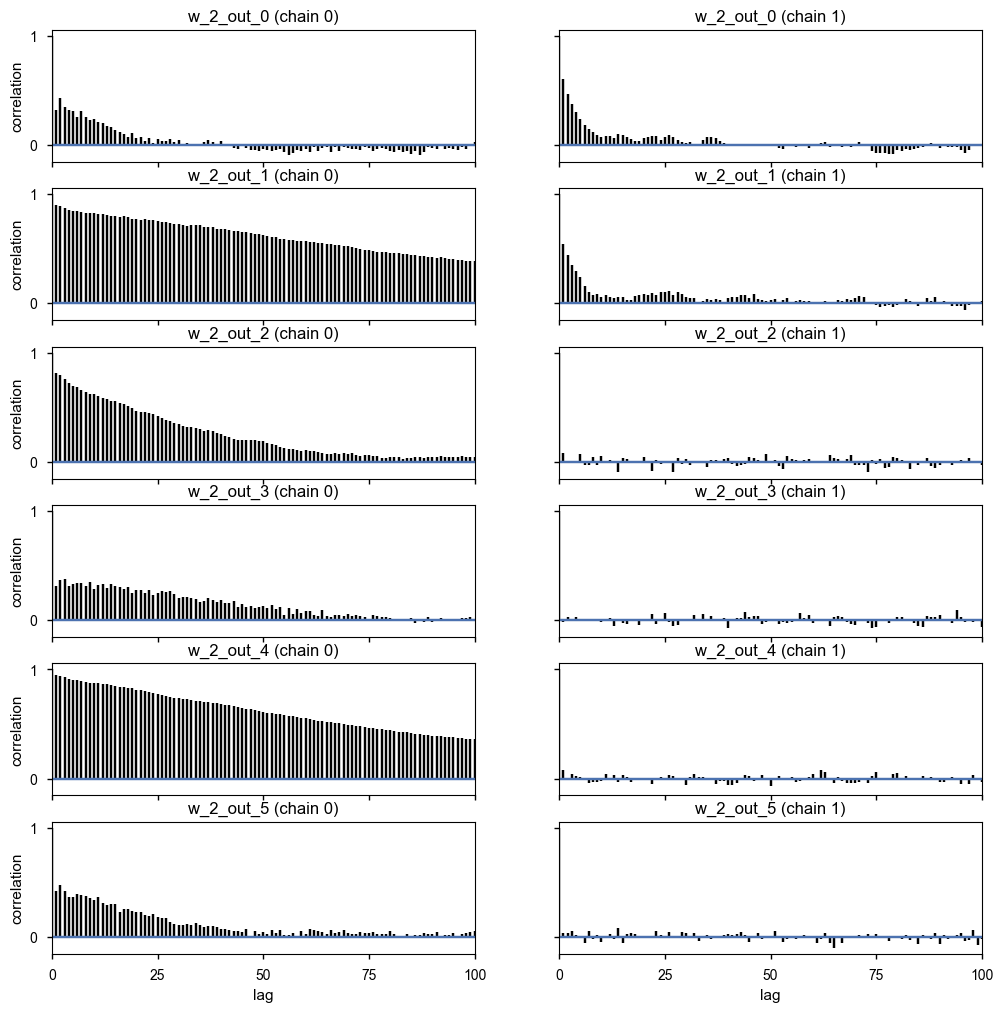

In [943]:
plt.style.use('default')
sns.set_context("notebook",font_scale=1)
autocorrplots_nuts = pm.plots.autocorrplot(trace, varnames=["w_2_out"])
plt.style.use('seaborn')
sns.set_context("poster",font_scale=1.4)

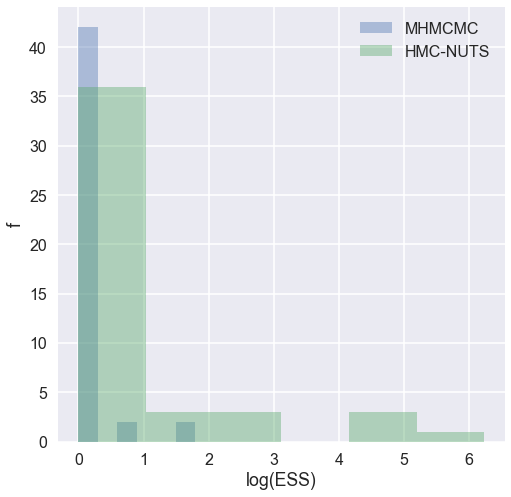

In [21]:
plt.figure(figsize=(8,8))
sns.distplot(np.log(results["mh_summary"]["n_eff"]), kde=False, label="MHMCMC")
sns.distplot(np.log(results["nuts_summary"]["n_eff"]), kde=False, label="HMC-NUTS")
_ = plt.legend()
_ = plt.ylabel("f")
_ = plt.xlabel("log(ESS)")
plt.savefig("ess.jpg",dpi=75)

In [955]:
results["X_train"] = X_train
results["y_train"] = y_train
results["X_test"] = X_test
results["y_test"] = y_test
results["nuts_trace"] = trace
results["nuts_ppc"] = ppc
results["nuts_summary"] = summary_hmc
results["mh_summary"] = summary_mh
results["nuts_acplots"] = autocorrplots_nuts
results["mh_acplots"] = autocorrplots_mh

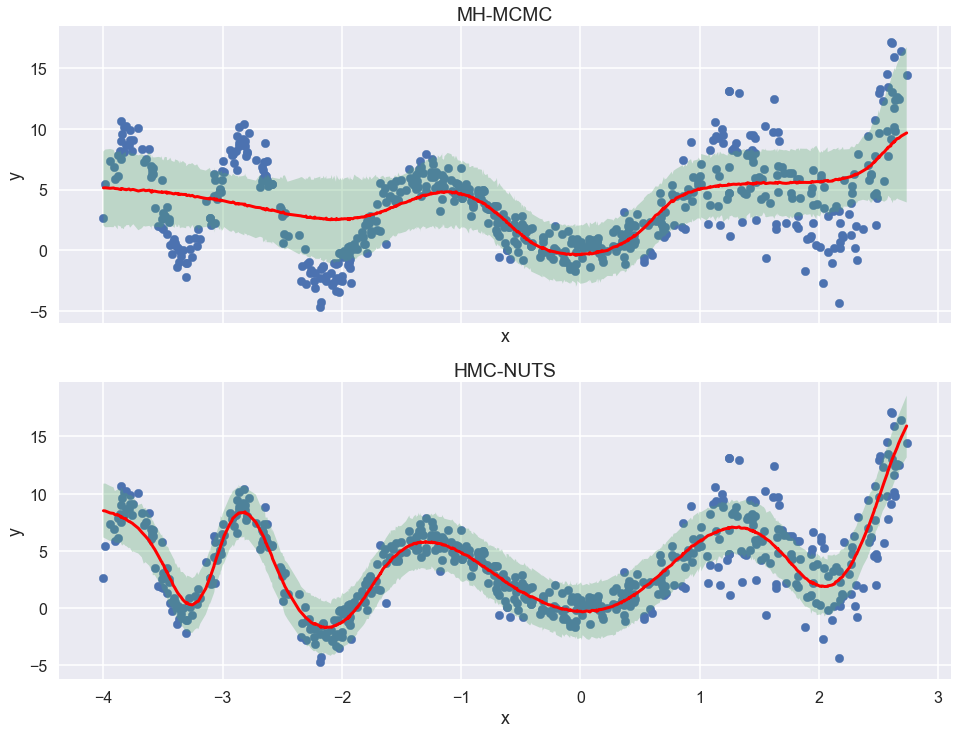

In [25]:
plot_both(results["X_test"], results["y_test"], results["mh_ppc"], results["nuts_ppc"])

In [8]:
"""
with open("ann-regression2.pkl","wb") as f:
    pickle.dump(results, f)
"""
with open("ann-regression.pkl","rb") as f:
    results= pickle.load(f)